In [1]:
#scRNAseq tutorial 4
# how can we compare clustering results?
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import smtplib
%pip install louvain
%pip install --upgrade igraph>=0.10,<0.12
import igraph as ig

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
/bin/bash: 0.12: No such file or directory
Note: you may need to restart the kernel to use updated packages.


In [2]:
# EXPERIMENT:
# How do cell-clusters calculated from different feature (gene) sets, compare to cell-types identified with FACs?
# APPROACH:
# Duo et al identified different types of immune cells before sequencing using FACs
# these labels are retained as the name for each cell in the gene x cell matrix
# Feature selection was computed using two different approaches to generate "HVGs" and "DDGs"
# we will perform Louvain clustering on raw gen x cell matrics, the HVG x cell matrix, and the DDG x cell matrix
# visualize how different the clusters are using t-SNE,
# then quantify the difference between the Louvain and FACS lables using the Adjusted Rand Index
xlabels = ["AllGenes_louvain:FACs","HVG_louvain:FACS", "DDG_louvain:FACS"]

#set directory
large_root = "/DATA05/home/jiwoolim24/test/scRNAseq_Workshop"
label = "Duo 8mix"
sc.settings.autoshow=False
sc.settings.figdir = large_root

# load gene counts x cell matrix (QC filtered)
raw_data = sc.read_csv(large_root + "/Duo_8mix_corr.csv", first_column_names = True)

/DATA05/home/jiwoolim24/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# load FACS labels
facs = pd.read_csv(large_root + "/Duo_8mix_id.csv")
facs = facs.set_index('Unnamed: 0')
facs_headers = list(facs.index)
top_clusterin=pd.DataFrame(index=facs_headers)
top_clusterin['FACS'] = facs_headers

In [4]:
# change cell-type annotations (from FACS) to numbers for color scheme input
top_clusterin = top_clusterin.replace('^.*b.cells.*$', '1', regex=True)
top_clusterin = top_clusterin.replace('^.*naive.c.*$', '2', regex=True)
top_clusterin = top_clusterin.replace('^.*cd14.*$', '3', regex=True)
top_clusterin = top_clusterin.replace('^.*regulatory.*$', '4', regex=True)
top_clusterin = top_clusterin.replace('^.*cd4.*$', '5', regex=True)
top_clusterin = top_clusterin.replace('^.*cd56.*$', '6', regex=True)
top_clusterin = top_clusterin.replace('^.*mem.*$', '7', regex=True)
top_clusterin = top_clusterin.replace('^.*naive.t.*$', '8', regex=True)

In [5]:
# calculate louvain clustering for raw data
print("Calculating Louvain for raw data")
keys_list = []
clustering =[]

Calculating Louvain for raw data


In [7]:
# compute neighborhood graph on non-reduced data (use_rep = 'X')
sc.pp.neighbors(raw_data,n_neighbors = 20, use_rep = 'X')
# compute community detection using louvain algorithm
sc.tl.louvain(raw_data,resolution = 0.5, key_added = "all_genes")
keys_list.append("all_genes")
# extract cluster labels from scanpy object and put in pandas dataframe
raw_clustering = raw_data.obs['all_genes']
raw_data.obs['facs'] = top_clusterin.FACS

/usr/local/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<Axes: title={'center': 'Duo 8mix all genes: cells colored by FACS'}, xlabel='tSNE1', ylabel='tSNE2'>

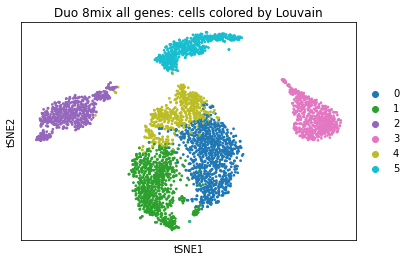

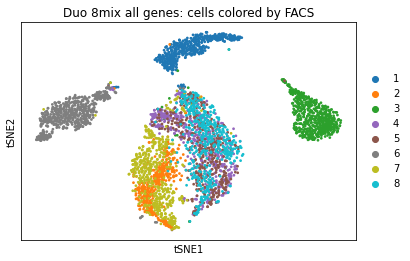

In [11]:
#visualize clusters using t-SNE
sc.tl.pca(raw_data, n_comps = 50)
sc.tl.tsne(raw_data, n_pcs = 50)
sc.pl.tsne(raw_data, color = ['all_genes'], title= [label + ' all genes: cells colored by Louvain'], palette = ('tab10'))
sc.pl.tsne(raw_data, color = ['facs'], title= [label + ' all genes: cells colored by FACS'], palette = ('tab10'))


<Axes: title={'center': 'Duo 8mix cells colored by CD52 expression'}, xlabel='tSNE1', ylabel='tSNE2'>

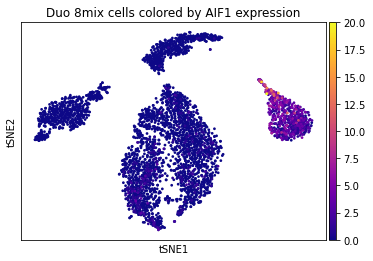

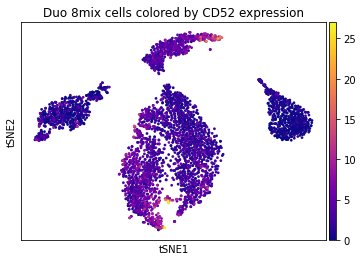

In [13]:
#feature selection
sc.pl.tsne(raw_data, color = ['AIF1'], title= [label + ' cells colored by AIF1 expression'], color_map = ('plasma'))
sc.pl.tsne(raw_data, color = ['CD52'], title= [label + ' cells colored by CD52 expression'], color_map = ('plasma'))

In [15]:
# to speed up demo, clustering and t-SNE was precomputed on HVG and DDG basis
# load cluster labels (for ARI calculation) and tSNE coordinates (for visualization)
HVG_clust = pd.read_csv(large_root + "/Duo_8mix_clusters.csv")
DDG_clust = pd.read_csv(large_root + "/Duo_8mix_SG_clusters.csv")
HVG_tsne_coords = pd.read_csv(large_root + "/Duo_8mix_TSNEcoords.csv")
DDG_tsne_coords = pd.read_csv(large_root + "/Duo_8mix_SG_TSNEcoords.csv")

In [16]:
# format data in dataframe
HVG_clust = HVG_clust.set_index('Unnamed: 0')
DDG_clust = DDG_clust.set_index('Unnamed: 0')
HVG_tsne_coords = HVG_tsne_coords.set_index('Unnamed: 0')
DDG_tsne_coords = DDG_tsne_coords.set_index('Unnamed: 0')


In [17]:
# create dataframes for easy plotting
HVG_tsne_coords['LV'] = HVG_clust['Cluster_Label']
HVG_tsne_coords['FACS'] = top_clusterin['FACS']
DDG_tsne_coords['LV'] = DDG_clust['Cluster_Label']
DDG_tsne_coords['FACS'] = top_clusterin['FACS']

HVG_clusters = HVG_clust['Cluster_Label']
DDG_clusters = DDG_clust['Cluster_Label']

In [19]:
# manually curated cluster colors to allow easy comparison of clusters
HVG_colors = ['dodgerblue', 'darkgreen', 'firebrick', 'rebeccapurple', \
               'turquoise', 'grey', 'darkorange', 'magenta']
DDG_colors = ['dodgerblue', 'darkgreen', 'firebrick', 'rebeccapurple', \
               'turquoise', 'grey', 'darkorange', 'magenta', 'yellowgreen']
FACS_colors = ['dodgerblue', 'darkgreen', 'firebrick', 'rebeccapurple', \
               'cyan', 'grey', 'darkorange', 'magenta']

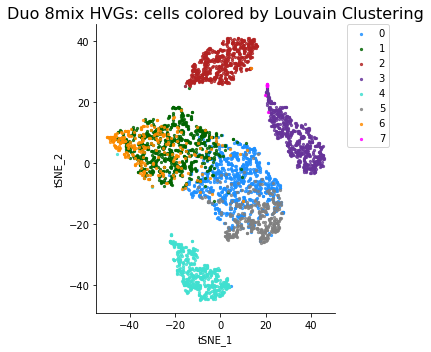

In [20]:
#plot tsne coords w categorical labels - clusters computed from HVGs
fs = 16
sns.set_palette(sns.color_palette(HVG_colors))
sns.lmplot( x="tSNE_1", y="tSNE_2", data=HVG_tsne_coords, fit_reg=False, hue='LV', legend=None, scatter_kws={"s": 5})
ax = plt.gca()
ax.set_title(label + " HVGs: cells colored by Louvain Clustering", fontsize=fs)
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

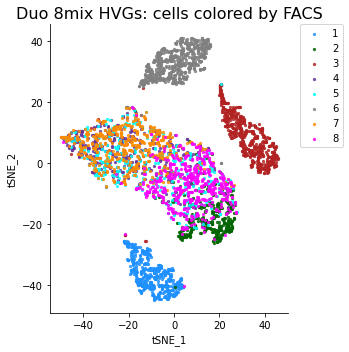

In [21]:
#plot tsne coords w categorical labels - t-SNE of HVGs, labeled by FACs
sns.set_palette(sns.color_palette(FACS_colors))
sns.lmplot( x="tSNE_1", y="tSNE_2", data=HVG_tsne_coords, fit_reg=False, hue='FACS', legend=None, scatter_kws={"s": 5})
ax = plt.gca()
ax.set_title(label + " HVGs: cells colored by FACS", fontsize=fs)
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [22]:
# the above figures tell that when we use the highly variable genes as a basis which enriches for those genes
# that have the most high variances relative to the mean
# we also see a loss of neighborhood structure in facs data

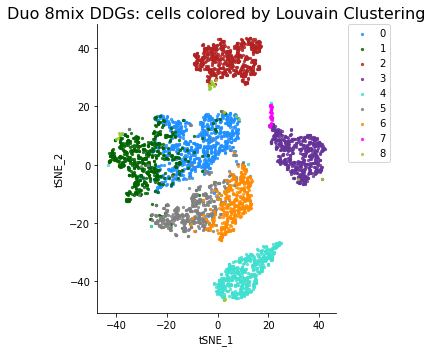

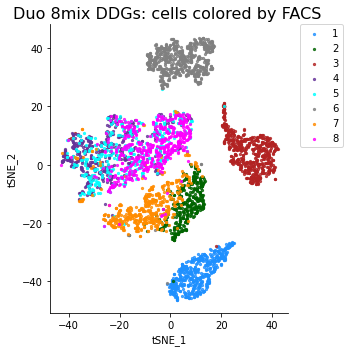

In [23]:
#plot tsne coords w categorical labels - clusters computed from DDGs, labeled by louvain
sns.set_palette(sns.color_palette(DDG_colors))
sns.lmplot( x="tSNE_1", y="tSNE_2", data=DDG_tsne_coords, fit_reg=False, hue='LV', legend=None, scatter_kws={"s": 5})
ax = plt.gca()
ax.set_title(label + " DDGs: cells colored by Louvain Clustering", fontsize=fs)
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

#plot tsne coords w categorical labels - t-SNE of DDGs, labeled using FACS
sns.set_palette(sns.color_palette(FACS_colors))
sns.lmplot( x="tSNE_1", y="tSNE_2", data=DDG_tsne_coords, fit_reg=False, hue='FACS', legend=None, scatter_kws={"s": 5})
ax = plt.gca()
ax.set_title(label + " DDGs: cells colored by FACS ", fontsize=fs)
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [24]:
# we can choose a more quantitiative method to compare how well these different feature selection methods do
# at recovering the original FACS label. To do this, use adjustged range index

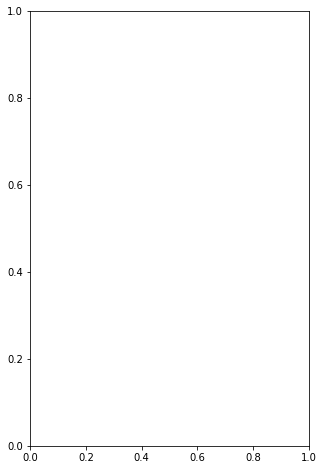

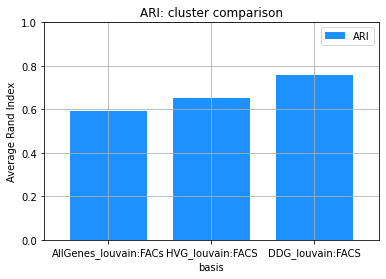

In [25]:
# quantify cluster similarity to FACs labels
# calculate ARI

ARI_summary = [(adjusted_rand_score(raw_clustering, top_clusterin.FACS)),
               (adjusted_rand_score(HVG_clusters, top_clusterin.FACS)),
               (adjusted_rand_score(DDG_clusters, top_clusterin.FACS))]
ARI = pd.DataFrame({'method': xlabels, 'ARI': ARI_summary})

#plot bar graph
fs = 12
fig = plt.figure(figsize=(5, 8))
ax = fig.add_subplot(111)
ax = ARI.plot.bar(x='method', y='ARI', rot=0, width = 0.75)
ax.set_title("ARI: cluster comparison", fontsize=fs)
ax.set_ylabel("Average Rand Index")
ax.set_xlabel("basis")
ax.set_ylim(0,1)
plt.grid()
